In [1]:
### For future improvements
### used MEAN values -> try with MEDIAN :: For AGE :: for TEST['FARE']
    ### Fill missed Fare in TEST.FARE data set with MEAN of all FAREs -> Try to use Pclass and othe correlated Features
### Droped 'Cabin' column with a lot of NA -> is it posible to fill and use it somehow
### Droped 'Embarked' rows with NA -> is it posible to fill and use it somehow
### 

## Load and examine DATA

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train=pd.read_csv('../input/train.csv') #, index_col='Id')
df_test=pd.read_csv('../input/test.csv') #, index_col='Id')

In [4]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [6]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null 

In [7]:
df_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
605,606,0,3,"Lindell, Mr. Edvard Bengtsson",male,36.0,1,0,349910,15.5500,NaN,S
431,432,1,3,"Thorneycroft, Mrs. Percival (Florence Kate White)",female,NaN,1,0,376564,16.1000,NaN,S
827,828,1,2,"Mallet, Master. Andre",male,1.0,0,2,S.C./PARIS 2079,37.0042,NaN,C


In [8]:
df_test.sample(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
246,1138,2,"Karnes, Mrs. J Frank (Claire Bennett)",female,22.0,0,0,F.C.C. 13534,21.000,NaN,S
32,924,3,"Dean, Mrs. Bertram (Eva Georgetta Light)",female,33.0,1,2,C.A. 2315,20.575,NaN,S
78,970,2,"Aldworth, Mr. Charles Augustus",male,30.0,0,0,248744,13.000,NaN,S


In [9]:
### Dealing with Missing Values

In [10]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [11]:
# df_train['Alley'].isnull().sum() = show number of NaN rows in 'Alley' column

In [12]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

In [13]:
def display_missing(df):
    for col in df.columns:
        print(col, df[col].isnull().sum())
    print('\n')
    
for df in dfs:
    print(format(df.name))
    display_missing(df)

Training Set
PassengerId 0
Survived 0
Pclass 0
Name 0
Sex 0
Age 177
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 687
Embarked 2


Test Set
PassengerId 0
Pclass 0
Name 0
Sex 0
Age 86
SibSp 0
Parch 0
Ticket 0
Fare 1
Cabin 327
Embarked 0




## Missed Values

In [14]:
"""### Dealing with missing values
to improve in future - may be not median of overall but 
Missing values in 'LotFrontage' feature are filled with the median LotFrontage, but using the median age of the whole data set is not a good choice. Median age of a group is much better because the new values would be more informative. Median age of Pclass groups is the best choice because of its high correlation with Age (0.408106) and Survived (0.338481) features
"""

"### Dealing with missing values\nto improve in future - may be not median of overall but \nMissing values in 'LotFrontage' feature are filled with the median LotFrontage, but using the median age of the whole data set is not a good choice. Median age of a group is much better because the new values would be more informative. Median age of Pclass groups is the best choice because of its high correlation with Age (0.408106) and Survived (0.338481) features\n"

In [15]:
df_train['Age'].describe()
df_train['Age'].head(6)

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
5     NaN
Name: Age, dtype: float64

# fill missing values for Age in Train and Test data set with MEAN value of TRAIN+TEST concatenated set
### !!! Should try in future to use MEAN only of TRAIN set to measure difference in accuracy

In [16]:
for df in dfs:
    df['Age'].fillna(value=df_all['Age'].mean(), inplace=True)

In [17]:
df_train.head(6)
#df_all['Age'].mean()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,29.881138,0,0,330877,8.4583,NaN,Q


### missed in Cabin

In [18]:
for df in dfs:
    print(format(df.name))
    display_missing(df)

Training Set
PassengerId 0
Survived 0
Pclass 0
Name 0
Sex 0
Age 0
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 687
Embarked 2


Test Set
PassengerId 0
Pclass 0
Name 0
Sex 0
Age 0
SibSp 0
Parch 0
Ticket 0
Fare 1
Cabin 327
Embarked 0




### Drop column 'Cabin' as it has a lot of NA value. Drop made by threshhold by info from describe
### !!! to check in future version - correlation Cabin-Survived

In [19]:
df_train.dropna(thresh=250, axis='columns', inplace=True)

## another example of droping 
#df_train.drop(columns='Cabin', inplace=False).head()

In [20]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [21]:
df_test.drop(columns='Cabin', inplace=False).head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


In [22]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [23]:
for df in dfs:
    print(format(df.name))
    display_missing(df)

Training Set
PassengerId 0
Survived 0
Pclass 0
Name 0
Sex 0
Age 0
SibSp 0
Parch 0
Ticket 0
Fare 0
Embarked 2


Test Set
PassengerId 0
Pclass 0
Name 0
Sex 0
Age 0
SibSp 0
Parch 0
Ticket 0
Fare 1
Cabin 327
Embarked 0




### missed in Embarked

In [24]:
# Next missed values in 'Embarked' column. Show missing values df_all[of True missed Value by column 'Embarked']
# We only see NA rows in TRAIN data set, let's have first try just drop them
#df_all[df_all['Embarked'].isnull()]
df_train[df_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


In [25]:
df_test[df_test['Embarked'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [26]:
df_train.dropna(inplace=True)

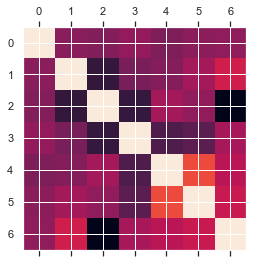

In [27]:
import matplotlib.pyplot as plt

plt.matshow(df_train.corr())
plt.show()

In [28]:
df_train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005028,-0.035330,0.030186,-0.057686,-0.001657,0.012703
Survived,-0.005028,1.000000,-0.335549,-0.075181,-0.034040,0.083151,0.255290
Pclass,-0.035330,-0.335549,1.000000,-0.326982,0.081656,0.016824,-0.548193
Age,0.030186,-0.075181,-0.326982,1.000000,-0.231766,-0.178927,0.088043
SibSp,-0.057686,-0.034040,0.081656,-0.231766,1.000000,0.414542,0.160887
Parch,-0.001657,0.083151,0.016824,-0.178927,0.414542,1.000000,0.217532
Fare,0.012703,0.255290,-0.548193,0.088043,0.160887,0.217532,1.000000


In [29]:
df_train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005028,-0.035330,0.030186,-0.057686,-0.001657,0.012703
Survived,-0.005028,1.000000,-0.335549,-0.075181,-0.034040,0.083151,0.255290
Pclass,-0.035330,-0.335549,1.000000,-0.326982,0.081656,0.016824,-0.548193
Age,0.030186,-0.075181,-0.326982,1.000000,-0.231766,-0.178927,0.088043
SibSp,-0.057686,-0.034040,0.081656,-0.231766,1.000000,0.414542,0.160887
Parch,-0.001657,0.083151,0.016824,-0.178927,0.414542,1.000000,0.217532
Fare,0.012703,0.255290,-0.548193,0.088043,0.160887,0.217532,1.000000


In [30]:
for df in dfs:
    print(format(df.name))
    display_missing(df)

Training Set
PassengerId 0
Survived 0
Pclass 0
Name 0
Sex 0
Age 0
SibSp 0
Parch 0
Ticket 0
Fare 0
Embarked 0


Test Set
PassengerId 0
Pclass 0
Name 0
Sex 0
Age 0
SibSp 0
Parch 0
Ticket 0
Fare 1
Cabin 327
Embarked 0




In [31]:
df_train[df_train['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked


In [32]:
df_test[df_test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [33]:
df_train.shape

(889, 11)

In [34]:
df_test.shape

(418, 11)

### Fill missed Fare in TEST.FARE data set with MEAN of all FAREs -> Try to use Pclass and othe correlated Features

In [35]:
### Fill missed Fare in TEST.FARE data set with MEAN of all FAREs
df_test['Fare'].fillna(df_all['Fare'],inplace=True)

In [36]:
df_test[df_test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [37]:
for df in dfs:
    print(format(df.name))
    display_missing(df)

Training Set
PassengerId 0
Survived 0
Pclass 0
Name 0
Sex 0
Age 0
SibSp 0
Parch 0
Ticket 0
Fare 0
Embarked 0


Test Set
PassengerId 0
Pclass 0
Name 0
Sex 0
Age 0
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 327
Embarked 0




#### Visualize correlation of numerical values (non-categorical)

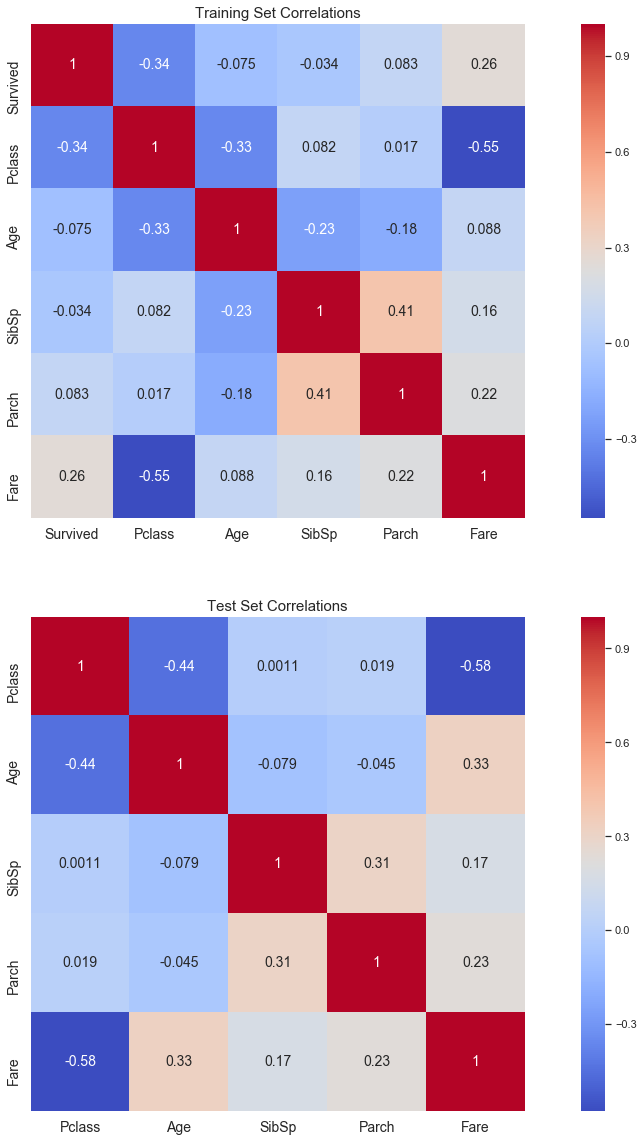

In [38]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(df_train.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, 
            cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(df_test.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, 
            cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

## Categorical Data

#### Fit and Predict without using categorical Data

# Machine Learning

In [39]:
#X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
#y_train = df_train['Survived'].values
#X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

#print('X_train shape: {}'.format(X_train.shape))
#print('y_train shape: {}'.format(y_train.shape))
#print('X_test shape: {}'.format(X_test.shape))

In [40]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

In [41]:
#y_train = df_train['Survived'].values
y_train = df_train['Survived'].values
drop_columns= ['PassengerId', 'Survived']
X_train = df_train.drop(columns=drop_columns)
X_val= df_test.drop(columns='PassengerId')

In [42]:
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [43]:
y_val=pd.read_csv('../input/submissions.csv')

## !! Loading Submition data from good model, to experiment and measure mistakes

In [44]:
y_val.drop(columns=['PassengerId'], inplace=True)
y_val.head()

,Survived
0,0
1,1
2,0
3,0
4,1


## !! Exlude all objects columns (categorical features) in data set (just to measure)

In [45]:
X_val_no_obj = X_val.select_dtypes(exclude=['object'])
X_train_no_obj = X_train.select_dtypes(exclude=['object'])

In [46]:
X_val.dtypes

Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [50]:
#forest_model = RandomForestRegressor()
forest_model = RandomForestClassifier
forest_model.fit(X_train_no_obj, y_train)
survival_preds = forest_model.predict(X_val_no_obj)
print(mean_squared_error(y_val, survival_preds))
print(mean_absolute_error(y_val, survival_preds))

TypeError: fit() missing 1 required positional argument: 'y'

In [49]:
survival_preds

array([0.2       , 0.        , 0.6       , 0.7       , 0.5       ,
       0.5       , 0.        , 0.8       , 0.6       , 0.3       ,
       0.        , 0.275     , 0.7       , 0.1       , 0.4       ,
       0.7       , 0.34      , 0.8       , 0.5       , 0.1       ,
       0.8       , 0.4       , 0.2       , 0.7       , 0.7       ,
       0.1       , 0.9       , 0.9       , 0.7       , 0.1       ,
       0.3       , 0.8       , 0.1       , 0.1       , 1.        ,
       0.6       , 0.        , 0.1       , 0.1       , 0.69      ,
       0.1       , 0.59      , 0.        , 0.35071429, 0.7       ,
       0.3       , 0.3       , 0.42549851, 0.7       , 0.2       ,
       1.        , 0.2       , 1.        , 0.6       , 0.7       ,
       0.        , 0.        , 0.        , 0.68333333, 0.8       ,
       0.1       , 0.8       , 0.        , 0.8       , 0.8       ,
       0.5       , 0.8       , 0.        , 0.2       , 0.6       ,
       0.3       , 0.        , 0.8       , 0.5       , 0.8    